In [1]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# 1) Cài đặt & Import thư viện
# =============================
# Ghi chú: Cell này sẽ tự cài các thư viện cần thiết nếu thiếu.

import sys
import subprocess
import importlib


def ensure_package(pkg_name: str):
    try:
        importlib.import_module(pkg_name)
    except ImportError:
        print(f"Installing {pkg_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg_name])

# Bắt buộc
for pkg in [
    "numpy",
    "pandas",
    "scikit-learn",
    "matplotlib",
    "seaborn",
    "tensorflow",
]:
    ensure_package(pkg)

# Import sau khi đã đảm bảo có đủ package
import os
import re
import random
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Thiết lập random seed cho tái lập
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Thông tin thiết bị
print("TensorFlow version:", tf.__version__)
print("Num GPUs available:", len(tf.config.list_physical_devices('GPU')))

# Đường dẫn dữ liệu
BASE_DIR = Path.cwd()  # notebook đang ở case2
DATA_PATH = BASE_DIR / "IMDB Dataset.csv"
print("Data path:", DATA_PATH)

# Thông số token/padding/mô hình mặc định
MAX_NUM_WORDS = 20000      # kích thước từ vựng tối đa
MAX_SEQUENCE_LENGTH = 200  # độ dài chuỗi sau padding
EMBEDDING_DIM = 100        # số chiều embedding
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3



Installing scikit-learn ...


KeyboardInterrupt: 

In [18]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# ================================
# 2) Load dữ liệu & kiểm tra nhanh
# ================================
# Dataset Kaggle chuẩn: cột 'review' (text) và 'sentiment' ('positive'/'negative')

df = pd.read_csv(DATA_PATH)
print(df.head())
print("\nShape:", df.shape)
print("\nCột:", df.columns.tolist())

# Kiểm tra phân bố nhãn
print("\nPhân bố sentiment:")
print(df["sentiment"].value_counts())

# Loại bỏ các dòng null nếu có
df = df.dropna(subset=["review", "sentiment"]).reset_index(drop=True)
print("\nSau khi dropna:", df.shape)



                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Shape: (50000, 2)

Cột: ['review', 'sentiment']

Phân bố sentiment:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Sau khi dropna: (50000, 2)


In [19]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# =============================================
# 3) Tiền xử lý văn bản: lowercase, clean ký tự
# =============================================
# - Chuyển lowercase
# - Loại HTML tags, URL
# - Loại ký tự đặc biệt / số, chỉ giữ chữ cái và khoảng trắng
# - Rút gọn khoảng trắng

HTML_TAG_RE = re.compile(r"<.*?>")
URL_RE = re.compile(r"https?://\S+|www\.\S+")
NON_ALPHA_RE = re.compile(r"[^a-zA-Z\s]")
MULTI_SPACE_RE = re.compile(r"\s+")


def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(HTML_TAG_RE, " ", text)
    text = re.sub(URL_RE, " ", text)
    text = re.sub(NON_ALPHA_RE, " ", text)
    text = re.sub(MULTI_SPACE_RE, " ", text).strip()
    return text

# Map sentiment sang nhãn số: positive->1, negative->0
label_mapping = {"positive": 1, "negative": 0}
df["label"] = df["sentiment"].map(label_mapping)

# Áp dụng tiền xử lý
print("Tiền xử lý văn bản... (có thể mất vài giây)")
df["clean_review"] = df["review"].apply(clean_text)

# Tách train/test (giữ phân phối nhãn bằng stratify)
X = df["clean_review"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Số mẫu train:", len(X_train), "| test:", len(X_test))



Tiền xử lý văn bản... (có thể mất vài giây)
Số mẫu train: 40000 | test: 10000


In [20]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# ===============================================
# 4) Tokenize từ vựng & Padding chuỗi cố định
# ===============================================

# Tokenizer học từ train để tránh leakage
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Chuyển text -> sequence (danh sách id từ)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad/cut chuỗi về cùng chiều dài
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
print(f"Vocab size sử dụng: {vocab_size}")
print("X_train_pad shape:", X_train_pad.shape)
print("X_test_pad shape:", X_test_pad.shape)



Vocab size sử dụng: 20000
X_train_pad shape: (40000, 200)
X_test_pad shape: (10000, 200)


In [21]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# ================================================
# 4b) Load/Save Tokenizer và đồng bộ lại dữ liệu
# ================================================

import os, pickle

if os.path.exists("tokenizer.pkl"):
    with open("tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)
    print("Loaded tokenizer from 'tokenizer.pkl'.")
    # Đồng bộ lại sequence/padding theo tokenizer đã load
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
    print(f"Vocab size (loaded tokenizer): {vocab_size}")
else:
    with open("tokenizer.pkl", "wb") as f:
        pickle.dump(tokenizer, f)
    print("Saved tokenizer to 'tokenizer.pkl'.")



Saved tokenizer to 'tokenizer.pkl'.


In [22]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# =====================================
# 5) Xây dựng mô hình Embedding + LSTM
# =====================================

def build_lstm_model(vocab_size: int,
                     embedding_dim: int = EMBEDDING_DIM,
                     input_length: int = MAX_SEQUENCE_LENGTH,
                     learning_rate: float = LEARNING_RATE) -> tf.keras.Model:
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        Bidirectional(LSTM(128, return_sequences=False)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

lstm_model = build_lstm_model(vocab_size)
lstm_model.summary()



C:\Users\Aspire 7\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# ============================================
# 6) Train 10 epochs & Evaluate cho LSTM model
# ============================================

import os

# Nếu đã có model đã train thì load và bỏ qua bước fit
if os.path.exists("lstm_model.keras"):
    lstm_model = tf.keras.models.load_model("lstm_model.keras")
    print("Loaded saved LSTM model from 'lstm_model.keras'. Skipping training.")
    class _Hist:
        def __init__(self):
            self.history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}
    history_lstm = _Hist()
else:
    history_lstm = lstm_model.fit(
        X_train_pad,
        y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    lstm_model.save("lstm_model.keras")
    print("Saved LSTM model to 'lstm_model.keras'.")

# Đánh giá trên test set
test_loss_lstm, test_acc_lstm = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\n[LSTM] Test Accuracy: {test_acc_lstm:.4f}")

# Classification report
y_pred_prob_lstm = lstm_model.predict(X_test_pad, verbose=0).ravel()
y_pred_lstm = (y_pred_prob_lstm >= 0.5).astype(int)
print("\n[LSTM] Classification Report:\n")
print(classification_report(y_test, y_pred_lstm, target_names=["negative", "positive"]))



Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 118s 401ms/step - accuracy: 0.7367 - loss: 0.5221 - val_accuracy: 0.8250 - val_loss: 0.4089
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 124s 439ms/step - accuracy: 0.8828 - loss: 0.2980 - val_accuracy: 0.8775 - val_loss: 0.3133
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 114s 403ms/step - accuracy: 0.9157 - loss: 0.2278 - val_accuracy: 0.8720 - val_loss: 0.3639
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 131s 466ms/step - accuracy: 0.9293 - loss: 0.1956 - val_accuracy: 0.8457 - val_loss: 0.4036
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 122s 433ms/step - accuracy: 0.9425 - loss: 0.1600 - val_accuracy: 0.7897 - val_loss: 0.5968
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 133s 471ms/step - accuracy: 0.9532 - loss: 0.1313 - val_accuracy: 0.8520 - val_loss: 0.4220
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 131s 466ms/step - accuracy: 0.9669 - loss: 0.0971 - val_accuracy: 0.8295 - val_loss: 0.6360
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 128s 417ms/step - accuracy: 0.9650 -

In [24]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# ====================================
# 7) Xây dựng mô hình Embedding + GRU
# ====================================

def build_gru_model(vocab_size: int,
                    embedding_dim: int = EMBEDDING_DIM,
                    input_length: int = MAX_SEQUENCE_LENGTH,
                    learning_rate: float = LEARNING_RATE) -> tf.keras.Model:
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        Bidirectional(GRU(128, return_sequences=False)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

gru_model = build_gru_model(vocab_size)
gru_model.summary()



C:\Users\Aspire 7\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# ==========================================
# 8) Train 10 epochs & Evaluate cho GRU model
# ==========================================

import os

# Nếu đã có model đã train thì load và bỏ qua bước fit
if os.path.exists("gru_model.keras"):
    gru_model = tf.keras.models.load_model("gru_model.keras")
    print("Loaded saved GRU model from 'gru_model.keras'. Skipping training.")
    class _Hist:
        def __init__(self):
            self.history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}
    history_gru = _Hist()
else:
    history_gru = gru_model.fit(
        X_train_pad,
        y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    gru_model.save("gru_model.keras")
    print("Saved GRU model to 'gru_model.keras'.")

# Đánh giá trên test set
test_loss_gru, test_acc_gru = gru_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\n[GRU] Test Accuracy: {test_acc_gru:.4f}")

# Classification report
y_pred_prob_gru = gru_model.predict(X_test_pad, verbose=0).ravel()
y_pred_gru = (y_pred_prob_gru >= 0.5).astype(int)
print("\n[GRU] Classification Report:\n")
print(classification_report(y_test, y_pred_gru, target_names=["negative", "positive"]))



Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 98s 335ms/step - accuracy: 0.7535 - loss: 0.4773 - val_accuracy: 0.8322 - val_loss: 0.3808
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 87s 309ms/step - accuracy: 0.8956 - loss: 0.2685 - val_accuracy: 0.8733 - val_loss: 0.3092
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 101s 359ms/step - accuracy: 0.9246 - loss: 0.2065 - val_accuracy: 0.8683 - val_loss: 0.3424
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 110s 391ms/step - accuracy: 0.9431 - loss: 0.1606 - val_accuracy: 0.8630 - val_loss: 0.3677
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 95s 337ms/step - accuracy: 0.9558 - loss: 0.1303 - val_accuracy: 0.8655 - val_loss: 0.4027
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 100s 356ms/step - accuracy: 0.9602 - loss: 0.1111 - val_accuracy: 0.8695 - val_loss: 0.4492
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 103s 367ms/step - accuracy: 0.9767 - loss: 0.0688 - val_accuracy: 0.8515 - val_loss: 0.6295
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 98s 349ms/step - accuracy: 0.9834 - los

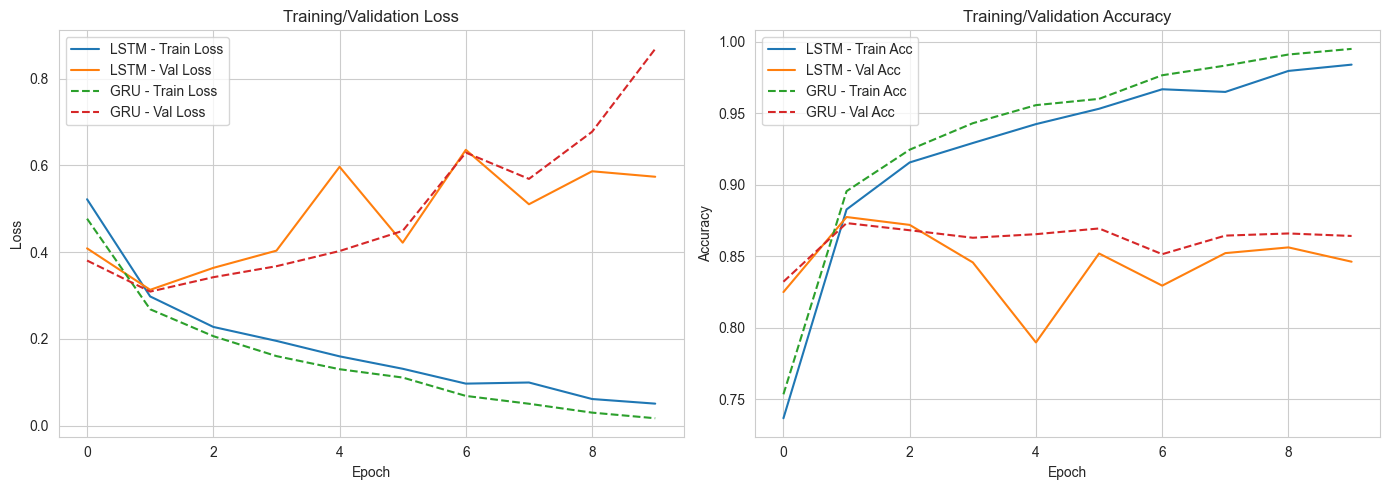

[LSTM] Test Accuracy: 0.8486
[GRU]  Test Accuracy: 0.8674


In [26]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# ===========================================
# 9) Vẽ biểu đồ Loss/Accuracy cho 2 mô hình
# ===========================================

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history_lstm.history['loss'], label='LSTM - Train Loss')
axes[0].plot(history_lstm.history['val_loss'], label='LSTM - Val Loss')
axes[0].plot(history_gru.history['loss'], label='GRU - Train Loss', linestyle='--')
axes[0].plot(history_gru.history['val_loss'], label='GRU - Val Loss', linestyle='--')
axes[0].set_title('Training/Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history_lstm.history['accuracy'], label='LSTM - Train Acc')
axes[1].plot(history_lstm.history['val_accuracy'], label='LSTM - Val Acc')
axes[1].plot(history_gru.history['accuracy'], label='GRU - Train Acc', linestyle='--')
axes[1].plot(history_gru.history['val_accuracy'], label='GRU - Val Acc', linestyle='--')
axes[1].set_title('Training/Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"[LSTM] Test Accuracy: {test_acc_lstm:.4f}")
print(f"[GRU]  Test Accuracy: {test_acc_gru:.4f}")



In [27]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# ======================================
# 10) Demo dự đoán nhanh trên vài câu
# ======================================

def predict_sentences(model, sentences):
    cleaned = [clean_text(s) for s in sentences]
    seqs = tokenizer.texts_to_sequences(cleaned)
    pads = pad_sequences(seqs, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    probs = model.predict(pads, verbose=0).ravel()
    preds = ["positive" if p >= 0.5 else "negative" for p in probs]
    return list(zip(sentences, preds, probs))

sample_texts = [
    "This movie was absolutely wonderful! I loved the story and the acting.",
    "Terrible film. Waste of time, poor script and boring scenes.",
    "It had some good moments but overall it was mediocre.",
]

print("\nDự đoán với LSTM:")
for sent, label, prob in predict_sentences(lstm_model, sample_texts):
    print(f"- {sent}\n  => {label} (prob={prob:.3f})")

print("\nDự đoán với GRU:")
for sent, label, prob in predict_sentences(gru_model, sample_texts):
    print(f"- {sent}\n  => {label} (prob={prob:.3f})")




Dự đoán với LSTM:
- This movie was absolutely wonderful! I loved the story and the acting.
  => positive (prob=0.995)
- Terrible film. Waste of time, poor script and boring scenes.
  => negative (prob=0.000)
- It had some good moments but overall it was mediocre.
  => negative (prob=0.014)

Dự đoán với GRU:
- This movie was absolutely wonderful! I loved the story and the acting.
  => positive (prob=1.000)
- Terrible film. Waste of time, poor script and boring scenes.
  => negative (prob=0.000)
- It had some good moments but overall it was mediocre.
  => negative (prob=0.000)
